# Exercise: Predicting post-vaccination pneumococcal population structure with QP Model (Navajo population)

Here we will predict the post-vaccine strain frequencies based on pre-vaccine accessory gene frequencies

Make sure to update the paths accordingly!

## Import relevant packages

This commands loads the R to python integration

In [2]:
%load_ext rpy2.ipython

Then we import the necessary python packages

In [3]:
import pandas as pd
import numpy as np
import scipy as scipy
import sys
import random
import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri
import matplotlib.pyplot as plt
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import seaborn as sns

## QP tests

### Preparing data for QP tests

#### First, let's import and prepare the 'raw' data

In [3]:
# Import navajo presence absence matrix
navajo_pan_acc = pd.read_csv('~/nfds-tutorial/exercises/qp_prediction/data/clarc_condensed_presence_absence.csv')

In [36]:
navajo_pan_acc

,Dataset,Accession,GPSC,serotype,epoch,ACF55012.1,hflX,smc_2,PCV7_vaccine_type,hsdR_2,...,group_8340-queH-,group_7652-yheI_2-,group_10985-group_10990-,group_5359-sarA_1-,ybbH_1-ybbH_2-,ABJ53609.1-CBW33524.1-,gatA_2-group_584-,ACO20484.1-group_969-,group_10196-group_10215-,year
0,Navajo,ERR906946_G1_23F_1999,6,23F,E1,1,1,1,VT,1,...,1,1,0,1,1,1,0,0,0,1999
1,Navajo,ERR906947_G3_19A_2007,266,19F,E2,1,1,1,VT,1,...,1,1,0,1,1,1,1,0,1,2007
2,Navajo,ERR906949_G5_NT_2010,84,NT,E3,1,1,0,NVT,1,...,0,1,0,0,1,0,0,0,1,2010
3,Navajo,ERR906950_G5_19A_2010,1,19A,E3,1,1,1,NVT,1,...,1,1,0,1,1,1,0,1,0,2010
4,Navajo,ERR906951_G5_23B_2010,6,23B,E3,1,1,1,NVT,1,...,1,1,0,1,1,1,0,0,1,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,Navajo,ERR907885_G3_6B_2006,72,6C,E2,1,1,0,NVT,1,...,0,1,0,1,0,1,1,0,0,2006
933,Navajo,ERR907886_G3_34_2006,43,34,E2,1,1,1,NVT,1,...,1,1,0,1,1,1,0,0,1,2006
934,Navajo,ERR907887_G3_35A_2006,226,35A,E2,1,1,1,NVT,1,...,0,1,0,1,0,1,1,1,1,2006
935,Navajo,ERR907888_G3_19A_2007,4,19A,E2,1,1,1,NVT,1,...,0,1,0,1,1,1,1,0,0,2007


In [ ]:
# Import and attach metadata
meta_data = pd.read_excel('~/nfds-tutorial/exercises/qp_prediction/data/MMN-meta-clean.xlsx')
navajo_pan_acc_meta = meta_data.merge(navajo_pan_acc, on='Accession')

In [7]:
navajo_pan_acc = navajo_pan_acc_meta.copy()

# Add column with vaccine type (VT or NVT, for PCV7)
# (PCV7 targets the following vaccine types = "4", "6A", "6B", "9V", "14", "18C", "19F", "23F")

# Add vaccine type column
navajo_pan_acc.insert(7, 'PCV7_vaccine_type', "NVT")
# Determine vaccine using previously outlined cutoffs
navajo_pan_acc.loc[(navajo_pan_acc['serotype'] == '4') | (navajo_pan_acc['serotype'] == '6A') | (navajo_pan_acc['serotype'] == '6B') | (navajo_pan_acc['serotype'] == '9V') | (navajo_pan_acc['serotype'] == '14') | (navajo_pan_acc['serotype'] == '18C') | (navajo_pan_acc['serotype'] == '19F') | (navajo_pan_acc['serotype'] == '23F'), 'PCV7_vaccine_type'] = 'VT'

# Separate by Epoch in Navajo dataset

# Extracting last 4 digits of 'Filename' to generate 'year' column
year = navajo_pan_acc.loc[:,'Accession'].str[-4:]
navajo_pan_acc.loc[:,'year'] = year

# Changing 'year' datatype to numeric, to do logical operations
navajo_pan_acc['year'] = navajo_pan_acc.loc[:,'year'].astype('int64')

# Add Epoch column
navajo_pan_acc.insert(4, 'epoch', " ")

# Determine epoch using previously outlined cutoffs
navajo_pan_acc.loc[(navajo_pan_acc['year'] >= 1998) & (navajo_pan_acc['year'] <= 2001), 'epoch'] = 'E1'
navajo_pan_acc.loc[(navajo_pan_acc['year'] >= 2006) & (navajo_pan_acc['year'] <= 2008), 'epoch'] = 'E2'
navajo_pan_acc.loc[(navajo_pan_acc['year'] >= 2010) & (navajo_pan_acc['year'] <= 2012), 'epoch'] = 'E3'

# Get datasets per epoch
navajo_e1 = navajo_pan_acc.loc[navajo_pan_acc['epoch'] == 'E1'].copy()
navajo_e2 = navajo_pan_acc.loc[navajo_pan_acc['epoch'] == 'E2'].copy()
navajo_e3 = navajo_pan_acc.loc[navajo_pan_acc['epoch'] == 'E3'].copy()

#### Let's check which GPSCs are mixed, which are VT and which are NVT

In [9]:
# First let's sort by GPSC
navajo_all_gpsc = navajo_pan_acc.sort_values(by='GPSC')

# Now let's group by GPSC, and then loop through each group to see which GPSC are VT, NVT, or mixed
navajo_all_grouped_gpsc = navajo_pan_acc.groupby(['GPSC'])

# There is a total of 71 GPSCs in the Navajo dataset

# Next, checks if GPSC is mixed (contains both VT and NVT isolates). True = It is mixed, False = It is not mixed
navajo_all_gpsc_ismixed = navajo_pan_acc.groupby(['GPSC']).PCV7_vaccine_type.apply(lambda x: len(set(x)) != 1)

# There are 64 pure GPSCs and 7 mixed GPSCs accross all epochs

# Get mixed GPSCs
mixed_gpsc = navajo_all_gpsc_ismixed[navajo_all_gpsc_ismixed == True]
mixed_gpsc_list = list(mixed_gpsc.index)

# The mixed GPSCs are: 5, 6, 9, 10, 11, 17, 266

# 102 is VT

# Now let's group E3 by GPSC
navajo_e3_grouped_gpsc = navajo_e3.groupby(['GPSC'])

# What GPSCs appear at E3?
navajo_e3_gpsc_ismixed = navajo_e3.groupby(['GPSC']).PCV7_vaccine_type.apply(lambda x: len(set(x)) != 1)

# 43 GPSCs appear at E3

#### Calculating M input for each population

In [10]:
# Now, let's calculate the observed COG frequencies per GPSC
# (this will be the first part of the input, of the population for which strain frequencies are being calculated)

# First we get rid of the unnecessary columns

# Navajo all epochs
navajo_all_f = navajo_pan_acc.drop(columns=['epoch','serotype','year','Dataset','Accession','PCV7_vaccine_type'])

# Navajo E1
navajo_e1_f = navajo_e1.drop(columns=['epoch','serotype','year','Dataset','Accession','PCV7_vaccine_type'])

#Navajo E2
navajo_e2_f = navajo_e2.drop(columns=['epoch','serotype','year','Dataset','Accession','PCV7_vaccine_type'])

#Navajo E3
navajo_e3_f = navajo_e3.drop(columns=['epoch','serotype','year','Dataset','Accession','PCV7_vaccine_type'])

In [11]:
# Now we determine the frequency of each COG per GPSC
#(and we transpose + sort by alphabetical order for consistency with QP function input)

# Important: Only the GPSCs that contain >5 isolates in the Navajo dataset to be predicted are being taken into account here, all others are dropped

# Navajo E1
navajo_e1_freq = navajo_e1_f.groupby(['GPSC']).mean()
navajo_e1_freq = navajo_e1_freq.transpose()
navajo_e1_freq = navajo_e1_freq.sort_index(axis=0)
navajo_e1_freq = navajo_e1_freq.reset_index()
navajo_e1_freq = navajo_e1_freq.rename(columns={"index": "COG_identifier"})
navajo_e1_freq = navajo_e1_freq.rename_axis(None, axis=1)

# Navajo E2
navajo_e2_freq = navajo_e2_f.groupby(['GPSC']).mean()
navajo_e2_freq = navajo_e2_freq.transpose()
navajo_e2_freq = navajo_e2_freq.sort_index(axis=0)
navajo_e2_freq = navajo_e2_freq.reset_index()
navajo_e2_freq = navajo_e2_freq.rename(columns={"index": "COG_identifier"})
navajo_e2_freq = navajo_e2_freq.rename_axis(None, axis=1)

# Navajo E3
navajo_e3_freq = navajo_e3_f.groupby(['GPSC']).mean()
navajo_e3_freq = navajo_e3_freq.transpose()
navajo_e3_freq = navajo_e3_freq.sort_index(axis=0)
navajo_e3_freq = navajo_e3_freq.reset_index()
navajo_e3_freq = navajo_e3_freq.rename(columns={"index": "COG_identifier"})
navajo_e3_freq = navajo_e3_freq.rename_axis(None, axis=1)

#### Calculating E input for each population

In [13]:
# Now to determine global COG frequencies (not per strain)
# (this is the second input of the QP function, for the population that is being used to predict strain frequencies)

# Navajo E1
navajo_e1_gf = navajo_e1.iloc[:,5:]
navajo_e1_gf = navajo_e1_gf.drop(columns=['year','PCV7_vaccine_type'])
navajo_e1_gfreq = navajo_e1_gf.mean()
navajo_e1_gfreq = navajo_e1_gfreq.sort_index(axis=0)

# Navajo E2
navajo_e2_gf = navajo_e2.iloc[:,5:]
navajo_e2_gf = navajo_e2_gf.drop(columns=['year','PCV7_vaccine_type'])
navajo_e2_gfreq = navajo_e2_gf.mean()
navajo_e2_gfreq = navajo_e2_gfreq.sort_index(axis=0)

# Navajo E3
navajo_e3_gf = navajo_e3.iloc[:,5:]
navajo_e3_gf = navajo_e3_gf.drop(columns=['year','PCV7_vaccine_type'])
navajo_e3_gfreq = navajo_e3_gf.mean()
navajo_e3_gfreq = navajo_e3_gfreq.sort_index(axis=0)

In [14]:
df1 = navajo_e1_gfreq.to_frame()
df1 = df1.reset_index()
df1.columns = ['condensed_cog','navajo_e1_freq']
df2 = navajo_e2_gfreq.to_frame()
df2 = df2.reset_index()
df2.columns = ['condensed_cog','navajo_e2_freq']
df3 = navajo_e3_gfreq.to_frame()
df3 = df3.reset_index()
df3.columns = ['condensed_cog','navajo_e3_freq']

In [15]:
navajo_condensedcogs_freqs = df1.merge(df2,on='condensed_cog').merge(df3,on='condensed_cog')

In [35]:
navajo_condensedcogs_freqs

,condensed_cog,navajo_e1_freq,navajo_e2_freq,navajo_e3_freq
0,AAK74208.1,0.047445,0.050251,0.086792
1,AAK74209.1-group_1475-,0.098540,0.108040,0.150943
2,AAK74219.1-group_2107-,0.186131,0.173367,0.177358
3,AAK74275.1,0.503650,0.658291,0.667925
4,AAK74276.1-ACO23808.1-,0.302920,0.304020,0.362264
...,...,...,...,...
2307,yycB,0.828467,0.811558,0.784906
2308,zmpB,0.868613,0.836683,0.796226
2309,zmpC,0.131387,0.103015,0.116981
2310,zmpD,0.197080,0.233668,0.226415


#### Preparing the input for QP result plotting function (in each population)

In [17]:
# Finally, let's calculate the observed strain prevalences for each population
# (These are the values against which the QP predictions will be compared)
# To be input into the function, the output of the QP model must be appended to these dataframes under the name "SC_pred"

# Navajo all

# Only get GPSC info
navajo_all_gpsc = navajo_pan_acc[['GPSC']]

# Count number of isolates in each GPSC
navajo_all_gpscount = navajo_all_gpsc.groupby(['GPSC']).value_counts()
navajo_all_gpscount = navajo_all_gpscount.reset_index()
navajo_all_gpscount.columns = ["GPSC","GPSC_count"]

# Drop GPSCs that have 5 or less isolates
navajo_all_gpscount = navajo_all_gpscount.loc[navajo_all_gpscount["GPSC_count"] > 5 ]

# Get list of GPSCs with <= 5 isolates accross all epochs
navajo_over5_alle = list(navajo_all_gpscount['GPSC'])

# Get list of GPSCs at E3
navajo_e3_freq_index = navajo_e3_freq.set_index(navajo_e3_freq.columns[0])
navajo_gpsc_e3 = list(navajo_e3_freq_index.columns)

# Get intersect of these lists
navajo_e3_over5 = list(set(navajo_over5_alle) & set(navajo_gpsc_e3))

# Calculate frequencies

#Drop isolates not in the needed GPSCs
navajo_e3_need_gpsc = navajo_e3[navajo_e3.GPSC.isin(navajo_e3_over5)]

# Only get GPSC info
navajo_e3_gpsc = navajo_e3_need_gpsc[['GPSC']]

# Count number of isolates in each GPSC
navajo_e3_gpscount = navajo_e3_gpsc.groupby(['GPSC']).value_counts()
navajo_e3_gpscount = navajo_e3_gpscount.reset_index()
navajo_e3_gpscount.columns = ["GPSC","GPSC_count"]

# Now, calculate the frequency 
navajo_e3_total = navajo_e3_gpscount['GPSC_count'].sum()
navajo_e3_gpscount['GPSC_freq'] = navajo_e3_gpscount['GPSC_count']/navajo_e3_total

# Finally, create dataframe in the format that the QP plot function takes
pred_navajo_e3 = navajo_e3_gpscount.drop(columns=['GPSC_count'])
pred_navajo_e3.insert(1, 'vaccine', "NVT") # This is MEANINGLESS, it's not actually making a distinction between NVT, mixed and VT. But it needs to have this format to go into the function.
pred_navajo_e3 = pred_navajo_e3.rename(columns={"GPSC_freq": "SC_obs"})

# Switch the mixed GPSCs to mixed (these are 5, 6, 9, 11, 17)
rows_loop = pred_navajo_e3.shape[0]

for i in range(rows_loop):
    
    value = pred_navajo_e3['GPSC'][i];
    
    if value in mixed_gpsc_list:       
        pred_navajo_e3['vaccine'][i] = 'mixed';
        
# Set VT type to NaN value (only GPSC 102 here)
pred_navajo_e3['vaccine'][25] = np.nan

/var/folders/pv/38jvkbgs585gpn940d76bwsh0000gn/T/ipykernel_51663/3570487743.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_navajo_e3['vaccine'][i] = 'mixed';
/var/folders/pv/38jvkbgs585gpn940d76bwsh0000gn/T/ipykernel_51663/3570487743.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_navajo_e3['vaccine'][i] = 'mixed';
/var/folders/pv/38jvkbgs585gpn940d76bwsh0000gn/T/ipykernel_51663/3570487743.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

#### Preparing for QP function - Dropping GPSC groups with < 5 isolates from M matrix

In [19]:
# Now, finally, since we are only predicting the GPSC with > 5 isolates in the predicted population
# we have to drop the GPSC with less than 5 isolated from the input COG frequency matrix

# For this, we take the list of names from the pred matrices and only keep those

# Navajo E3
navajo_e3_list = pred_navajo_e3.GPSC.values.tolist()
navajo_e3_freq_input = navajo_e3_freq[navajo_e3_freq.columns[navajo_e3_freq.columns.isin(navajo_e3_list)]]

#### Add ID column to input vector (for COG subsetting)

In [20]:
## Let's try to manually prepare the input matrix with COG subset

# I have to manually add the ID column to the vector

# Navajo E3
navajo_e3_list = pred_navajo_e3.GPSC.values.tolist()
navajo_e3_list.append('COG_identifier')
navajo_e3_freq_input_id = navajo_e3_freq[navajo_e3_freq .columns[navajo_e3_freq .columns.isin(navajo_e3_list)]]

## Functions for QP Tests

In [ ]:
%%R 
# Import necessary R packages
require(tidyverse)
require(quadprog)
require(pracma)
require(cowplot)
require(ggrepel)
require(magrittr)
require(corrplot)
require(psych)
require(gridExtra)
require(RColorBrewer)
require(lazyeval)
setwd("~/nfds-tutorial/exercises/qp_prediction/R_functions")

#### Load R functions from separate files into python

In [22]:
# Quadratic programming function
r_source = robjects.r['source']
r_source('~/nfds-tutorial/exercises/qp_prediction/R_functions/QP.R')
r_QP = robjects.globalenv['QP']

# Inputs need to be *Numpy Arrays*

In [23]:
# Function to plot QP output
r_source = robjects.r['source']
r_source('~/nfds-tutorial/exercises/qp_prediction/R_functions/plotPred.R')
r_plotPred = robjects.globalenv['plotPred']

# Input is a dataframe with 4 columns:
# "GPSC" = strain classification, can be any classification doesn't have to necessarily be GPSC
# "vaccine" = vaccine type of the strain, either VT or NVT
# "SC_obs" = strain prevalences that were observed in the population
# "SC_pred" = strain prevalences that were predicted with the QP model

In [24]:
# Function to get SSE number for prediction
r_source = robjects.r['source']
r_source('~/nfds-tutorial/exercises/qp_prediction/R_functions/SSEpred.R')
r_SSEpred = robjects.globalenv['SSEpred']

# Input is the same as plotPred

### Write additional python functions

#### Function to subset inputs based on list of COGs

In [25]:
# Function to subset data when trying to predict E3 from E1 values
def subset_input_E3_from_E1(subset):
    
    M = navajo_e3_freq_input_id
    E = navajo_e1_gfreq

    # Now, I take M and keep the COGs on the list, also drop identifier column
    M_subset = M[M.COG_identifier.isin(subset)]
    M_subset = M_subset.drop(columns=['COG_identifier'])

    # Likewise, I take E and remove the COGs on the list
    # Because I have E as a list, it needs to turn and unturn into a dataframe
    E = E.reset_index()
    E.columns = ["COG_identifier","E1_gfreq_observed"]
    E_subset = E[E.COG_identifier.isin(subset)]
    E_subset = E_subset.drop(columns=['COG_identifier'])

    return [M_subset,E_subset]

#### Function to get SSE distribution given a number of random COGs

In [26]:
# Navajo E3 from E1 freqs

# Next write a function that takes as input n = number of random COGs in the subset and t = number of times to run the simulation
# and it outputs sse_random which is a vector array of length t containing the SSEs results from each simulation run

# This is to predict E3 from E1

def SSE_rand(n,t):
    
    sse_random = []
    
    for x in range(t):
        
        # First let's get the subset COG list using my function
        subset = rand_COGlist(n)
        
        # Now, let's get the QP inputs with just the COG subsets
        [M_E3_subset, E_E1_subset] = subset_input_E3_from_E1(subset)
        
        # Then we switch the inputs to arrays
        M_E3_subset_array = M_E3_subset.to_numpy()
        E_E1_subset_array = E_E1_subset.to_numpy()
        
        # Run QP
        subset_E3fromE1_result = r_QP(M_E3_subset_array, E_E1_subset_array)
        
        # Add predicted GPSC prevalences to prediction matrix
        subset_E3_pred = pred_navajo_e3.copy()
        subset_E3_pred['SC_pred'] = subset_E3fromE1_result
        
        # Run SSEpred function to get SSE of the model
        SSE_subset_E3fromE1 = r_SSEpred(subset_E3_pred)
        result = SSE_subset_E3fromE1.item()
        # Append each loop
        sse_random.append(result)
        
    return(sse_random)

#### Function to get SSE of specific COG subset

In [27]:
# Navajo E3 from E1

# Write function that inputs l = the list of specific COGs to try on the simulation and t = title of the plot
# it will returns the QP plot R object and the SSE value of that subset's fit

# This is also predicting E3 from E1

def target_subset_test(l,title):
    
    # Get inputs subsetted by the list
    [M_E3_subset,E_E1_subset] = subset_input_E3_from_E1(l)
    
    # Switch input to arrays
    M_E3_subset_array = M_E3_subset.to_numpy()
    E_E1_subset_array = E_E1_subset.to_numpy()
    
    # Run QP
    subset_E3fromE1_result = r_QP(M_E3_subset_array, E_E1_subset_array)

    # Add predicted GPSC prevalences to prediction matrix
    subset_E3_pred = pred_navajo_e3.copy()
    subset_E3_pred['SC_pred'] = subset_E3fromE1_result

    # Run plotPred to obtain plot
    subset_COGs_E3fromE1_plot = r_plotPred(subset_E3_pred, title)

    # Run SSEpred function to get SSE of the model
    SSE_subset_E3fromE1 = r_SSEpred(subset_E3_pred)
    sse_result = SSE_subset_E3fromE1.item()
    
    return [subset_COGs_E3fromE1_plot, sse_result]

#### Function to get random list of n COGs (from the list of accessory COGs)

In [28]:
# Get the list of accessory COG names
navajo_e1_gfreq_names = navajo_e1_gfreq.reset_index()
navajo_e1_gfreq_names.columns = ["COG_identifier","E1_gfreq_observed"]

COG_names = list(navajo_e1_gfreq_names['COG_identifier'])

In [30]:
# Input is the number (n) of randomly selected COGs in the subset

def rand_COGlist(n):
    
    COG_list = COG_names 
    COG_subset_list = random.sample(COG_names , n)
    
    return(COG_subset_list)

## Run QP Tests with COG subsets

In [ ]:
cog_num = len(COG_names)
cog_num

In [42]:
# All eggnog COGs using subset function
title = f'GPSC prevalence prediction - E3 from E1 - {cog_num} condensed acc COGs'
[qp_plot, qp_sse] = target_subset_test(COG_names,title)

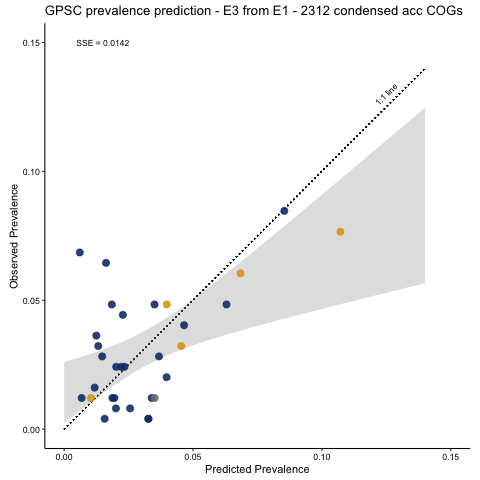

In [43]:
%%R -i qp_plot
qp_plotd